# OCR精度評価
## （正式評価 / OCRモデル / 99件 / 2025-12-14実施分）

各OCRモデルの出力をground_truthと比較し、精度を評価します。

## 評価指標
- **CER (Character Error Rate)**: 文字単位の誤り率
- **完全一致率**: ground_truthと完全に一致する割合

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import japanize_matplotlib
import unicodedata
import re

# Levenshtein距離計算用
try:
    import Levenshtein
except ImportError:
    print("Levenshteinライブラリをインストールしてください: pip install python-Levenshtein")

## データ読み込み

In [2]:
# CSVファイルのパス
csv_path = Path("../output/20251216-0930/_extracted/cropped/combined_texts.csv")

# CSVを読み込み（マルチライン対応）
df = pd.read_csv(csv_path, encoding='utf-8')

# ヘッダーを除く1〜100行目を取得（0-indexedで0〜100行目）
df = df.iloc[:100].copy()

print(f"読み込んだ行数: {len(df)}")
print(f"列名: {df.columns.tolist()}")
df.tail()

読み込んだ行数: 99
列名: ['filename', 'azure', 'upstage', 'yomitoku', 'ground_truth']


,filename,azure,upstage,yomitoku,ground_truth
94,ja_pii_handwriting_0936,蔵田握矢福島県いわき市三沢町五反田佐々木アパートE棟357号室平成14年07月31日06-7...,蔵田握矢 誘導した市波取細細を休アパートE業を例 06-7333-1136,蔵田握矢福島県いわき市三沢町五反田佐々木アパートE棟337号室平成14年07月31日06-7...,蔵田握矢 福島県いわき市三沢町五反田佐々木アパートE棟357号室 平成14年07月31日 0...
95,ja_pii_handwriting_0950,川津五左男 福島県双葉郡木葉町大字山田浜代東松田アパートC棟253号室 1983年07月04...,川 津 五左男 福島県 双葉郡楢葉町大字山田浜代東水田アパーC棟263号室 1983年 07...,川津五左男 福島県双葉郡稲葉町大字山田:浜代東北田アパトC棟253号室 1983年07月04...,川津五左男 福島県双葉郡楢葉町大字山田浜代東松田アパートC棟253号室 1983年07月04...
96,ja_pii_handwriting_0955,弟沢旱季子兵庫県川辺郡猪名川町木津御所垣内小林タウン1036号室1993.08.19 03-...,鵜沢勝子兵勝川辺郡猪名川町大津御平沢小林ラス山尻 1993.08.19 03-5081-2008,鵜沢野玉兵庫県川辺郡猪名川町小津御所小林タウン1036号室1993.08.08.19 03-...,鵜沢 早季子 兵庫県川辺郡猪名川町木津御所垣内小林タウン1036号室 1993.08.19 ...
97,ja_pii_handwriting_0973,玉井七穂子兵庫県西脇市 落方町 2008-8-2 1974.09.1006-4490-4220,五井 七穂子 兵庫県 西脇市 落方町 2008 - 8-2 1974 09. 10 06 -...,王子千千兵庫県西脇市 葛方町2008-8-2 1974.09.10 06-4490-4220,玉井七穂子 兵庫県西脇市落方町2008-8-2 1974.09.10 06-4490-4220
98,ja_pii_handwriting_0981,大黒右人東京都中央区晴海三丁目54番地-8号2003年05月24日080-4629-1666,大黒 右未人 東京都中央区晴海三丁目54番地 - 8号 2003年05月24日 080- 4...,大黒右未人 東京都中央区晴海三丁目54番地-8号 2003年05月24日 080-4629-...,大黒 右夫人 東京都中央区晴海三丁目54番地-8号 2003年05月24日 080-4629...


In [3]:
# 比較対象のモデル列
model_columns = ['azure', 'upstage', 'yomitoku']
ground_truth_column = 'ground_truth'

# 欠損値を空文字に置換
for col in model_columns + [ground_truth_column]:
    df[col] = df[col].fillna('').astype(str)

print("データの前処理完了")

データの前処理完了


## 評価関数の定義

### 前処理 (normalize_text)
1. 改行除去
2. NFKC正規化（全角数字・記号→半角）
3. 先頭のノイズ文字除去（`···`, `pr`, `im`等）
4. 全スペース除去（半角・全角）← オプションで切替可能

### 評価指標
- **CER (Character Error Rate)**: `編集距離 / ground_truthの文字数`
- **CER (スペース除去前)**: スペースを保持した状態でのCER
- **CER (スペース除去後)**: スペースを除去した状態でのCER
- **exact_match**: 正規化後のテキストが完全一致するか判定

In [4]:
# 先頭のノイズパターン（OCRのゴミ文字）
NOISE_PATTERNS = [
    r'^[·\.]{2,}\s*',      # 連続するドット
    r'^pr\s+',              # "pr "
    r'^im\s*',              # "im"
    r'^inc\s*',             # "inc"
    r'^int\s*',             # "int"
    r'^\d{3}\s+',           # 先頭の3桁数字+スペース (例: "111 ")
]

def normalize_text(text: str, remove_spaces: bool = True) -> str:
    """テキストの正規化（強化版）
    
    Args:
        text: 入力テキスト
        remove_spaces: Trueならスペースを除去、Falseなら連続スペースを1つに統一
    
    処理内容:
        1. 改行を除去
        2. NFKC正規化（全角→半角変換）
        3. 先頭のノイズ文字を除去
        4. スペース処理（除去 or 統一）
    """
    if pd.isna(text):
        return ''
    
    text = str(text)
    
    # 1. 改行を除去
    text = text.replace('\n', '').replace('\r', '')
    
    # 2. NFKC正規化（全角数字・記号を半角に変換）
    text = unicodedata.normalize('NFKC', text)
    
    # 3. 先頭のノイズパターンを除去
    for pattern in NOISE_PATTERNS:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    
    # 4. スペース処理
    if remove_spaces:
        # すべてのスペースを除去（半角・全角両方）
        text = text.replace(' ', '').replace('\u3000', '')
        text = re.sub(r'\s+', '', text)
    else:
        # 連続するスペースを1つに統一
        text = re.sub(r'[\s\u3000]+', ' ', text).strip()
    
    return text

def calculate_cer(prediction: str, ground_truth: str, remove_spaces: bool = True) -> float:
    """Character Error Rate (CER) を計算
    
    CER = (置換 + 挿入 + 削除) / ground_truthの文字数
    """
    pred = normalize_text(prediction, remove_spaces=remove_spaces)
    gt = normalize_text(ground_truth, remove_spaces=remove_spaces)
    
    if len(gt) == 0:
        return 0.0 if len(pred) == 0 else 1.0
    
    distance = Levenshtein.distance(pred, gt)
    return distance / len(gt)

def exact_match(prediction: str, ground_truth: str, remove_spaces: bool = True) -> bool:
    """完全一致を判定"""
    pred = normalize_text(prediction, remove_spaces=remove_spaces)
    gt = normalize_text(ground_truth, remove_spaces=remove_spaces)
    return pred == gt

# テスト用: 正規化の動作確認
print("正規化テスト:")
test_cases = [
    ("外山 茉梨 愛知県", "外山茉梨愛知県"),
    ("９５２号室", "952号室"),
    ("··· 釣 太見夫", "釣太見夫"),
]
for original, expected in test_cases:
    result_with_space = normalize_text(original, remove_spaces=False)
    result_no_space = normalize_text(original, remove_spaces=True)
    print(f"  原文: '{original}'")
    print(f"    スペース保持: '{result_with_space}'")
    print(f"    スペース除去: '{result_no_space}'")

正規化テスト:
  原文: '外山 茉梨 愛知県'
    スペース保持: '外山 茉梨 愛知県'
    スペース除去: '外山茉梨愛知県'
  原文: '９５２号室'
    スペース保持: '952号室'
    スペース除去: '952号室'
  原文: '··· 釣 太見夫'
    スペース保持: '釣 太見夫'
    スペース除去: '釣太見夫'


## 各モデルの精度算出

In [5]:
# 各行ごとの評価結果を格納（スペース除去前後の両方）
results = []

for idx, row in df.iterrows():
    gt = row[ground_truth_column]
    row_result = {'filename': row['filename']}
    
    for model in model_columns:
        pred = row[model]
        # スペース除去後のCER
        row_result[f'{model}_cer'] = calculate_cer(pred, gt, remove_spaces=True)
        # スペース保持のCER
        row_result[f'{model}_cer_with_space'] = calculate_cer(pred, gt, remove_spaces=False)
        # 完全一致（スペース除去後）
        row_result[f'{model}_exact'] = exact_match(pred, gt, remove_spaces=True)
    
    results.append(row_result)

results_df = pd.DataFrame(results)
print(f"評価完了: {len(results_df)}行")
results_df.head()

評価完了: 99行


,filename,azure_cer,azure_cer_with_space,azure_exact,upstage_cer,upstage_cer_with_space,upstage_exact,yomitoku_cer,yomitoku_cer_with_space,yomitoku_exact
0,ja_pii_handwriting_0001,0.000000,0.039216,True,0.000000,0.156863,True,0.021277,0.058824,False
1,ja_pii_handwriting_0022,0.000000,0.041667,True,0.000000,0.125000,True,0.044444,0.062500,False
2,ja_pii_handwriting_0031,0.037037,0.071429,False,0.018519,0.160714,False,0.055556,0.089286,False
3,ja_pii_handwriting_0038,0.142857,0.173077,False,0.163265,0.250000,False,0.163265,0.192308,False
4,ja_pii_handwriting_0040,0.000000,0.017857,True,0.615385,0.660714,False,0.019231,0.071429,False


In [6]:
# サマリー統計を計算（スペース除去前後の両方）
summary = {}

for model in model_columns:
    summary[model] = {
        'CER (除去後・平均)': results_df[f'{model}_cer'].mean(),
        'CER (除去後・中央値)': results_df[f'{model}_cer'].median(),
        'CER (除去前・平均)': results_df[f'{model}_cer_with_space'].mean(),
        'CER (除去前・中央値)': results_df[f'{model}_cer_with_space'].median(),
        '完全一致率': results_df[f'{model}_exact'].mean(),
        '完全一致数': results_df[f'{model}_exact'].sum(),
    }

summary_df = pd.DataFrame(summary).T
summary_df.index.name = 'Model'

print("=" * 70)
print("OCR精度評価サマリー")
print("=" * 70)
summary_df

OCR精度評価サマリー


,CER (除去後・平均),CER (除去後・中央値),CER (除去前・平均),CER (除去前・中央値),完全一致率,完全一致数
Model,,,,,,
azure,0.046782,0.020408,0.077542,0.056604,0.393939,39.0
upstage,0.083079,0.022222,0.207738,0.153846,0.343434,34.0
yomitoku,0.126557,0.044444,0.153272,0.080000,0.181818,18.0


## 結果の可視化

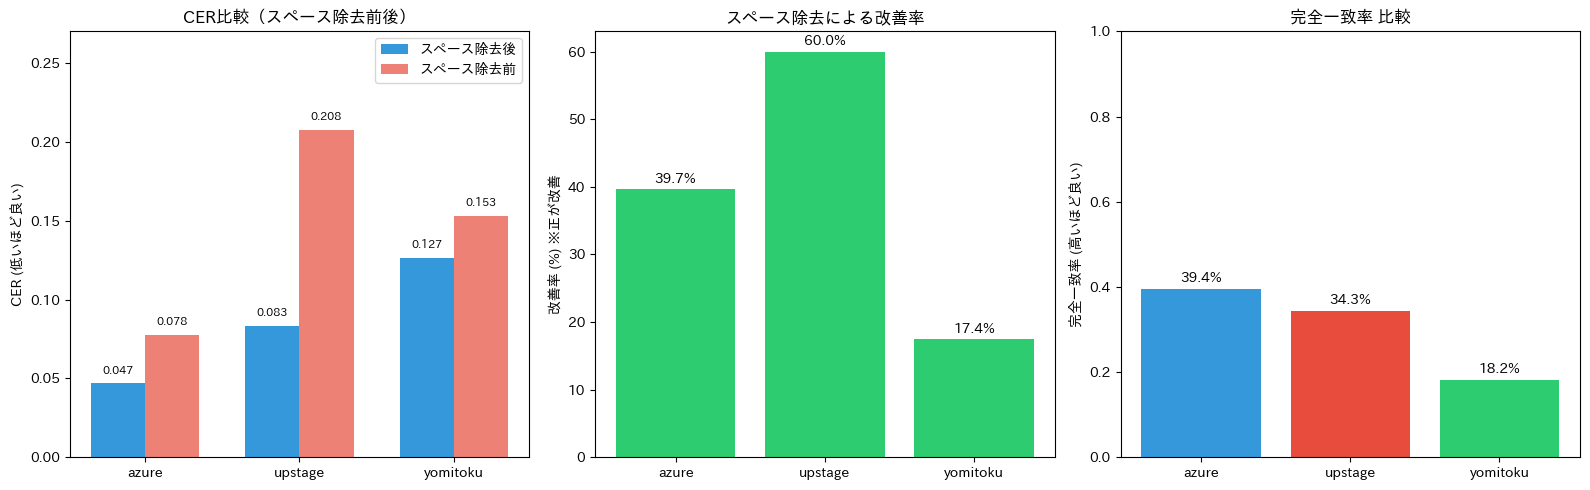

グラフを保存しました: ocr_accuracy_comparison.png


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# CER比較（スペース除去前後）
ax1 = axes[0]
x = np.arange(len(model_columns))
width = 0.35

cer_after = [summary_df.loc[model, 'CER (除去後・平均)'] for model in model_columns]
cer_before = [summary_df.loc[model, 'CER (除去前・平均)'] for model in model_columns]

bars1 = ax1.bar(x - width/2, cer_after, width, label='スペース除去後', color='#3498db')
bars2 = ax1.bar(x + width/2, cer_before, width, label='スペース除去前', color='#e74c3c', alpha=0.7)

ax1.set_title('CER比較（スペース除去前後）')
ax1.set_ylabel('CER (低いほど良い)')
ax1.set_xticks(x)
ax1.set_xticklabels(model_columns)
ax1.legend()
ax1.set_ylim(0, max(max(cer_after), max(cer_before)) * 1.3)

for bar, val in zip(bars1, cer_after):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=8)
for bar, val in zip(bars2, cer_before):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=8)

# CER改善率（スペース除去による改善）
ax2 = axes[1]
improvement = [(before - after) / before * 100 if before > 0 else 0 
               for before, after in zip(cer_before, cer_after)]
colors = ['#2ecc71' if imp > 0 else '#e74c3c' for imp in improvement]
bars3 = ax2.bar(model_columns, improvement, color=colors)
ax2.set_title('スペース除去による改善率')
ax2.set_ylabel('改善率 (%) ※正が改善')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

for bar, val in zip(bars3, improvement):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}%', ha='center', va='bottom', fontsize=10)

# 完全一致率比較
ax3 = axes[2]
exact_values = [summary_df.loc[model, '完全一致率'] for model in model_columns]
bars4 = ax3.bar(model_columns, exact_values, color=['#3498db', '#e74c3c', '#2ecc71', '#9b59b6'])
ax3.set_title('完全一致率 比較')
ax3.set_ylabel('完全一致率 (高いほど良い)')
ax3.set_ylim(0, 1.0)

for bar, val in zip(bars4, exact_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.1%}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../output/20251202-0942/extracted/ocr_accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("グラフを保存しました: ocr_accuracy_comparison.png")

## 詳細結果の出力

In [8]:
# 各行ごとのCERを表形式で表示
cer_detail = results_df[['filename'] + [f'{m}_cer' for m in model_columns]].copy()
cer_detail.columns = ['filename'] + model_columns

print("各ファイルごとのCER (Character Error Rate)")
print("=" * 60)
cer_detail.style.background_gradient(cmap='RdYlGn_r', subset=model_columns)

各ファイルごとのCER (Character Error Rate)


,filename,azure,upstage,yomitoku
0,ja_pii_handwriting_0001,0.000000,0.000000,0.021277
1,ja_pii_handwriting_0022,0.000000,0.000000,0.044444
2,ja_pii_handwriting_0031,0.037037,0.018519,0.055556
3,ja_pii_handwriting_0038,0.142857,0.163265,0.163265
4,ja_pii_handwriting_0040,0.000000,0.615385,0.019231
5,ja_pii_handwriting_0042,0.000000,0.000000,0.000000
6,ja_pii_handwriting_0044,0.020000,0.040000,0.040000
7,ja_pii_handwriting_0061,0.000000,0.000000,0.115385
8,ja_pii_handwriting_0065,0.020000,0.000000,0.040000
9,ja_pii_handwriting_0067,0.140000,0.020000,0.120000


In [9]:
# 完全一致の詳細
exact_detail = results_df[['filename'] + [f'{m}_exact' for m in model_columns]].copy()
exact_detail.columns = ['filename'] + model_columns

print("各ファイルごとの完全一致 (True=一致, False=不一致)")
print("=" * 60)
exact_detail.style.applymap(lambda x: 'background-color: #90EE90' if x else 'background-color: #FFB6C1', 
                            subset=model_columns)

各ファイルごとの完全一致 (True=一致, False=不一致)


/var/folders/75/829b2bn56z50f7qvkfx05k1w0000gn/T/ipykernel_12004/4246007147.py:7: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  exact_detail.style.applymap(lambda x: 'background-color: #90EE90' if x else 'background-color: #FFB6C1',


,filename,azure,upstage,yomitoku
0,ja_pii_handwriting_0001,True,True,False
1,ja_pii_handwriting_0022,True,True,False
2,ja_pii_handwriting_0031,False,False,False
3,ja_pii_handwriting_0038,False,False,False
4,ja_pii_handwriting_0040,True,False,False
5,ja_pii_handwriting_0042,True,True,True
6,ja_pii_handwriting_0044,False,False,False
7,ja_pii_handwriting_0061,True,True,False
8,ja_pii_handwriting_0065,False,True,False
9,ja_pii_handwriting_0067,False,False,False


In [10]:
# 結果をCSVに保存
output_path = Path("../output/20251216-0930/_extracted/cropped/ocr_accuracy_results.csv")
results_df.to_csv(output_path, index=False, encoding='utf-8')
print(f"詳細結果を保存しました: {output_path}")

# サマリーもCSVに保存
summary_path = Path("../output/20251216-0930/_extracted/cropped/ocr_accuracy_summary.csv")
summary_df.to_csv(summary_path, encoding='utf-8')
print(f"サマリーを保存しました: {summary_path}")

詳細結果を保存しました: ../output/20251216-0930/_extracted/cropped/ocr_accuracy_results.csv
サマリーを保存しました: ../output/20251216-0930/_extracted/cropped/ocr_accuracy_summary.csv
